# Importing libraries


In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Testing GPU

In [2]:
from tensorflow.python.client import device_lib

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Loading Data

Let's define the paths to our training and validation data folders:

- `train_path`: This is the training data (1000 images for each label)

- `valid_path`: This is the validation data(100 images for each label)



In [3]:
# Set paths to train and validation folders
train_path = "/kaggle/input/tomatoleaf/tomato/train"
valid_path = "/kaggle/input/tomatoleaf/tomato/val"

# Preprocessing Data with ImageDataGenerator

- `image_size`: Image size is set to (224, 224)

- `batch_size`: Batch size set to 32

- `train_datagen`: Used for augmenting training data.
    - `rescale=1.0/255`: Scaling pixel values to the range [0, 1] to ensure consistent input to the model.
    - `rotation_range=20`: Randomly rotating images by up to 20 degrees to introduce variety.
    - `width_shift_range=0.2` and `height_shift_range=0.2`: Shifting the image horizontally and vertically by up to 20% of the image width or height, respectively.
    - `shear_range=0.2`: Applying shear transformations to the images.
    - `zoom_range=0.2`: Zooming in or out on images by up to 20%.
    - `horizontal_flip=True`: Flipping images horizontally, which increases data diversity.




In [4]:
# Define image data generators with data augmentation
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [5]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Data Generators for Training and Validation

- `train_generator`: Load images from `train_path`
- `class_mode`: Predicts classes using one-hot encoding

- `valid_generator`: Load images from `valid_path`


In [6]:
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 10000 images belonging to 10 classes.


In [7]:
valid_generator = valid_datagen.flow_from_directory(
    directory=valid_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 1000 images belonging to 10 classes.


# Data Snapshot



In [8]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def display_random_images(directory, num_images=9, num_columns=3):
    subfolders = [subfolder for subfolder in os.listdir(directory) if os.path.isdir(os.path.join(directory, subfolder))]
    if len(subfolders) == 0:
        print(f"No subfolders found in {directory}")
        return
    
    random_subfolder = random.choice(subfolders)
    subfolder_path = os.path.join(directory, random_subfolder)
    image_files = [filename for filename in os.listdir(subfolder_path) if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) < num_images:
        print(f"Number of available images in {subfolder_path} is less than {num_images}")
        return
    
    random_files = random.sample(image_files, num_images)
    num_rows = (num_images + num_columns - 1) // num_columns
    plt.figure(figsize=(15, 10))
    
    for i, filename in enumerate(random_files):
        img_path = os.path.join(subfolder_path, filename)
        img = mpimg.imread(img_path)
        plt.subplot(num_rows, num_columns, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
    
    plt.tight_layout()
    plt.show()

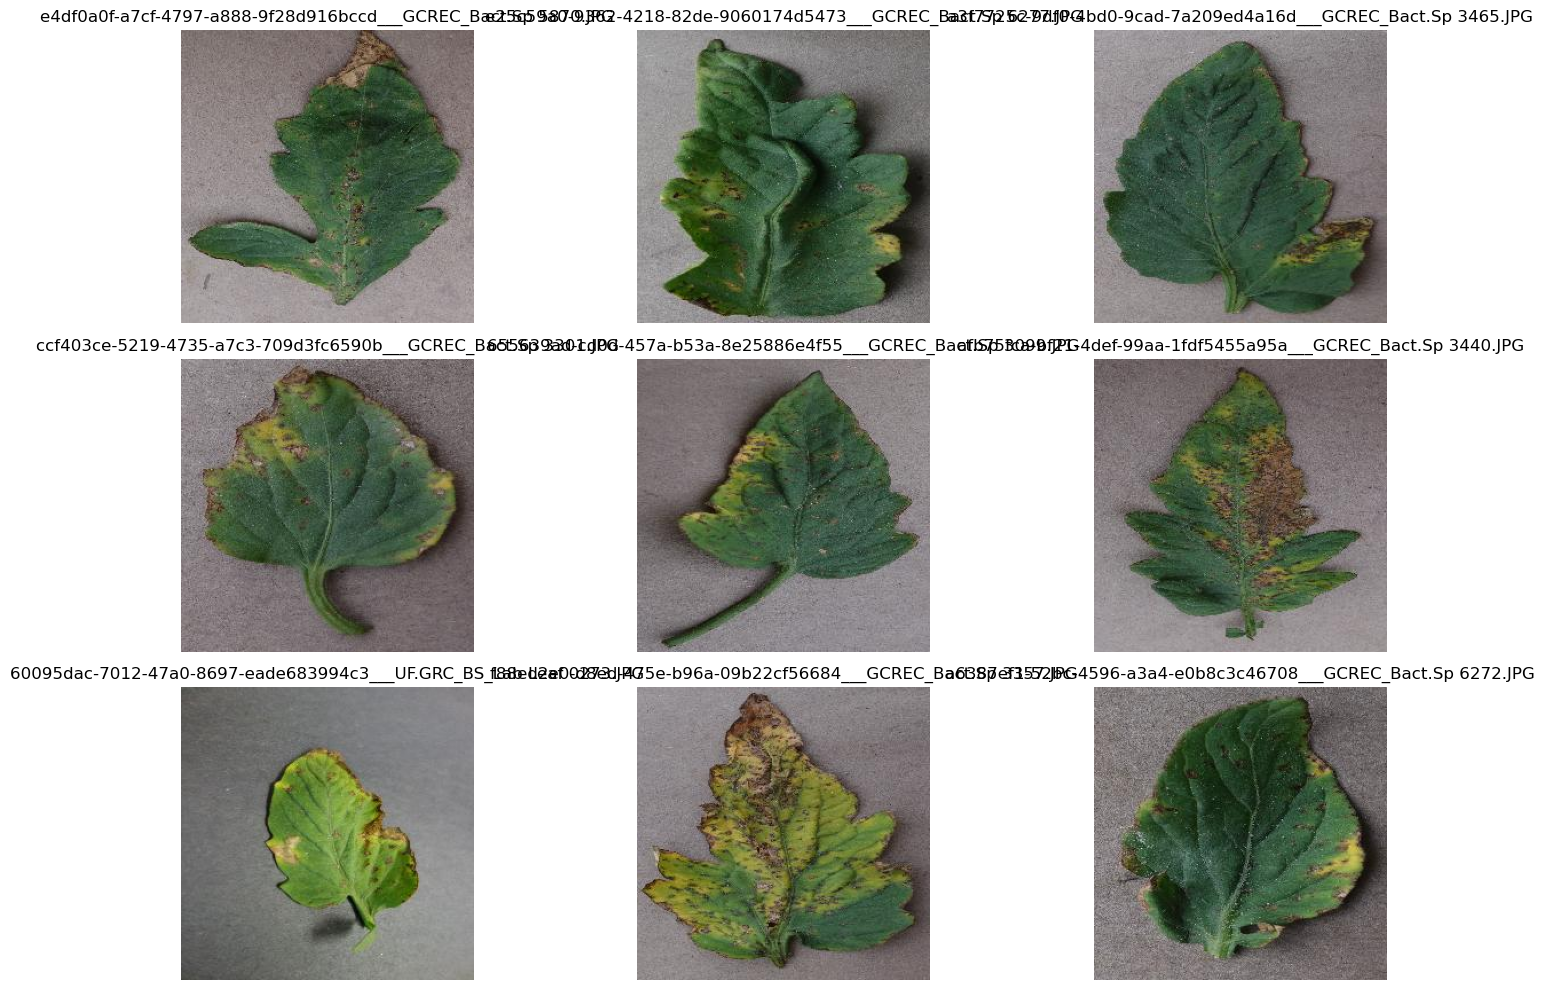

In [9]:
display_random_images(train_path, num_images=9, num_columns=3)


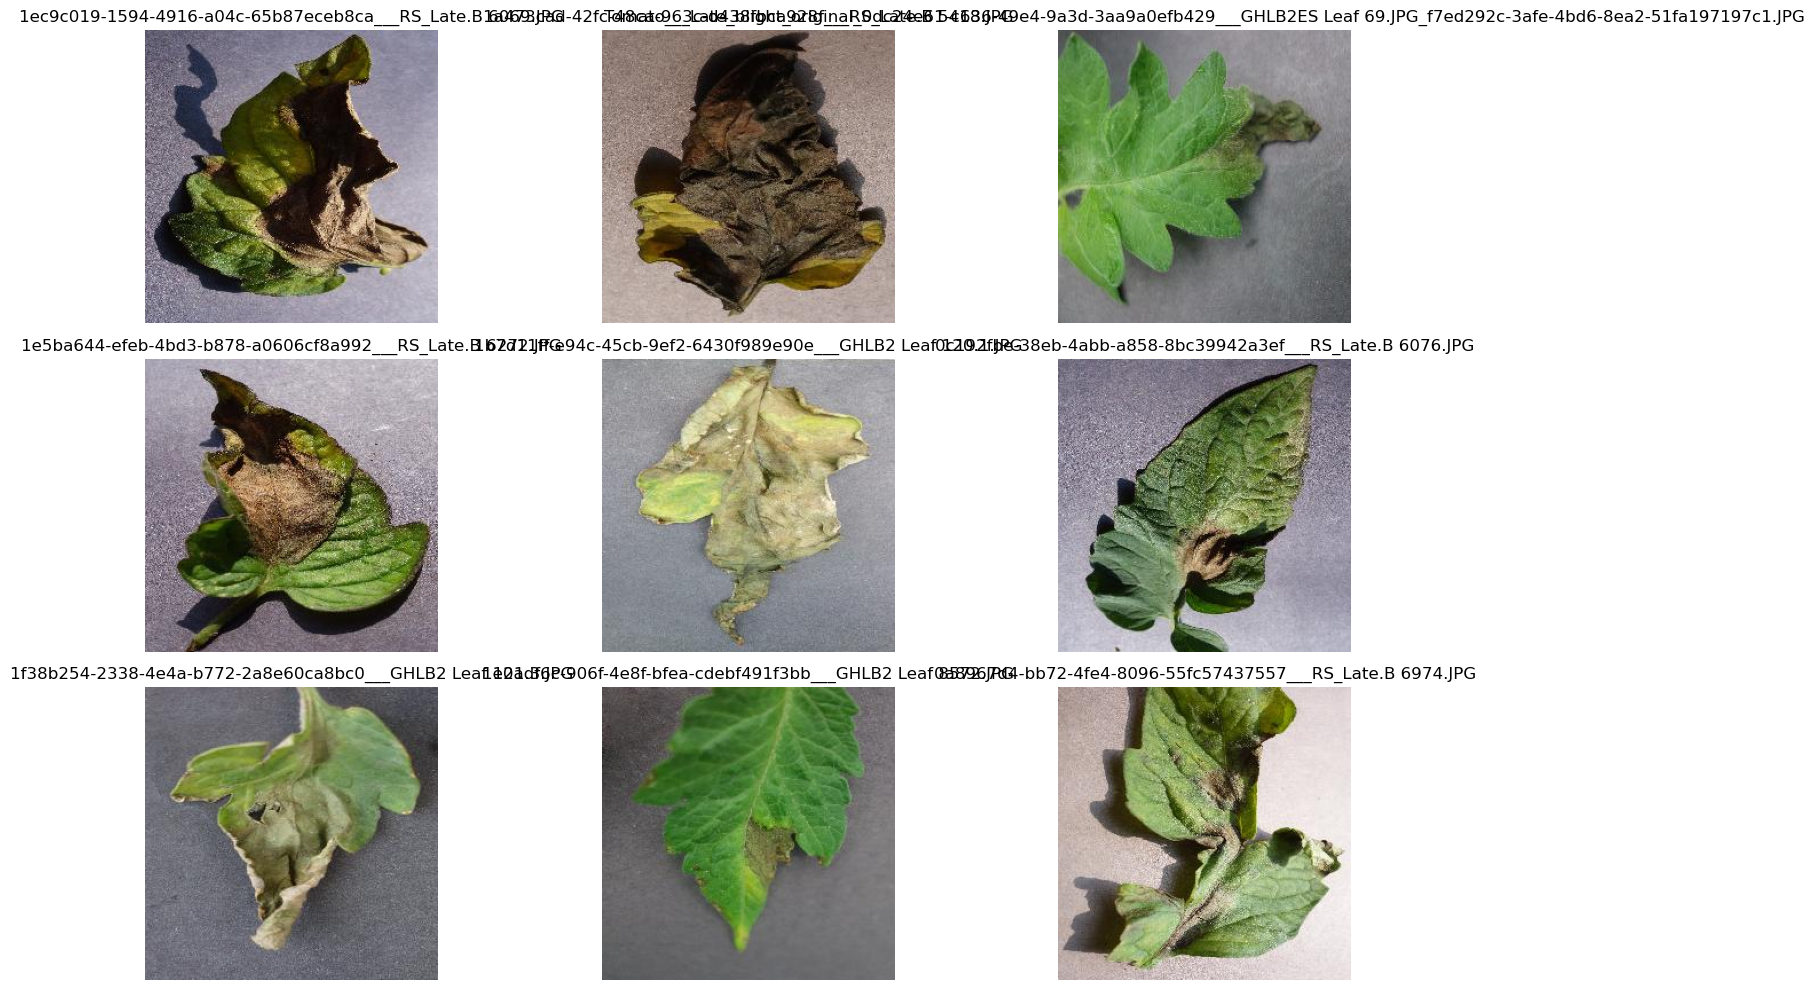

In [10]:
# Call the function with the desired directory and number of images
display_random_images(valid_path, num_images=9, num_columns=3)

# Define CNN model


- `num_classes`: 10 classes in the dataset

- `model = Sequential([...])`: 
    
    - `Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3))`
    
    - `MaxPooling2D(2, 2)`
    
    - `Conv2D(64, (3, 3), activation="relu")`
    
    - `MaxPooling2D(2, 2)`
    
    - `Flatten()`
    
    - `Dense(128, activation="relu")`
    
    - `Dropout(0.5)`
    
    - `Dense(num_classes, activation="softmax")`


In [11]:
# Define a CNN model
with tf.device('/device:GPU:0'):
    num_classes = len(train_generator.class_indices)
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])

# Compile and Training CNN model


- `model.compile(...)`
    - `optimizer=Adam(lr=0.0001)`
    - `loss="categorical_crossentropy"`
    - `metrics=["accuracy"]`

- `early_stopping = EarlyStopping(...)`
    - `monitor='val_accuracy'`
    - `patience=5`
    - `restore_best_weights=True`

- `model.fit(...)`
    - `epochs=50`
    - `callbacks=[early_stopping]`


In [12]:
from tensorflow.keras.optimizers import Adam
with tf.device('/device:GPU:0'):
    # Compile the model with Adam optimizer
    model.compile(
        optimizer=Adam(lr=0.0001),  # You can adjust the learning rate as needed
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
with tf.device('/device:GPU:0'):
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Train the model with EarlyStopping
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=50,
        validation_data=valid_generator,
        validation_steps=len(valid_generator),
        callbacks=[early_stopping]  # Add the EarlyStopping callback
    )

Epoch 1/50
313/313 [==============================] - 170s 507ms/step - loss: 1.9521 - accuracy: 0.3020 - val_loss: 1.4045 - val_accuracy: 0.5380
Epoch 2/50
313/313 [==============================] - 115s 368ms/step - loss: 1.3090 - accuracy: 0.5334 - val_loss: 1.0907 - val_accuracy: 0.6100
Epoch 3/50
313/313 [==============================] - 115s 367ms/step - loss: 1.0930 - accuracy: 0.6097 - val_loss: 1.1501 - val_accuracy: 0.6240
Epoch 4/50
313/313 [==============================] - 115s 367ms/step - loss: 0.9705 - accuracy: 0.6575 - val_loss: 1.3025 - val_accuracy: 0.6260
Epoch 5/50
313/313 [==============================] - 119s 381ms/step - loss: 0.8775 - accuracy: 0.6893 - val_loss: 1.6771 - val_accuracy: 0.5650
Epoch 6/50
313/313 [==============================] - 115s 367ms/step - loss: 0.8675 - accuracy: 0.6947 - val_loss: 0.8163 - val_accuracy: 0.7410
Epoch 7/50
313/313 [==============================] - 125s 400ms/step - loss: 0.8153 - accuracy: 0.7135 - val_loss: 1.3858 -

# Visualizing Training Progress



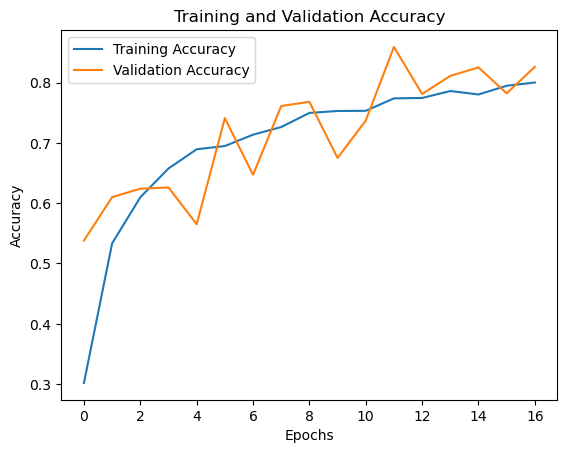

In [14]:
# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

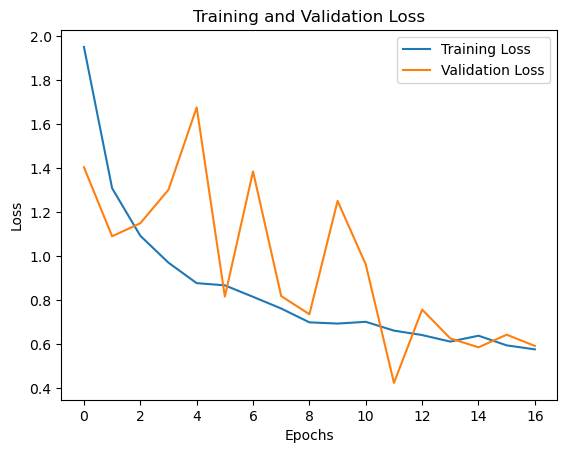

In [15]:
# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Evaluating the Model on Test Data


In [16]:
# Make predictions on test data
test_loss, test_accuracy = model.evaluate(valid_generator, steps=len(valid_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Save the trained model
model.save("big.h5")
print("model saved")

32/32 [==============================] - 2s 62ms/step - loss: 0.4236 - accuracy: 0.8590
Test Loss: 0.4236
Test Accuracy: 0.8590
model saved


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

# Confusion Matrix


1/1 [==============================] - 0s 69ms/step


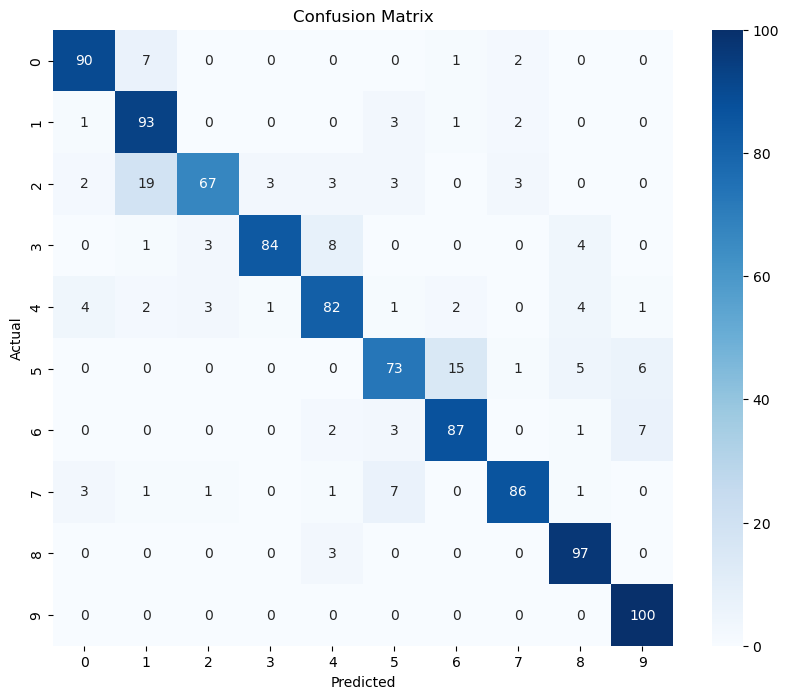

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
# Load the saved model
loaded_model = tf.keras.models.load_model("big.h5")

# Initialize variables
num_samples = len(valid_generator.filenames)
batch_size = 32
num_batches = int(np.ceil(num_samples / batch_size))
all_test_labels = []
all_predicted_labels = []

# Generate predictions in batches
for _ in range(num_batches):
    batch_images, batch_labels = next(valid_generator)
    batch_predictions = loaded_model.predict(batch_images)
    batch_predicted_labels = np.argmax(batch_predictions, axis=1)
    
    all_test_labels.extend(np.argmax(batch_labels, axis=1))
    all_predicted_labels.extend(batch_predicted_labels)

# Generate confusion matrix
cm = confusion_matrix(all_test_labels, all_predicted_labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names if available
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
model.save('big.h5')

In [ ]:
sample_image = mpimg.imread('/kaggle/input/tomatoleaf/tomato/val/Tomato___Bacterial_spot/01a3cf3f-94c1-44d5-8972-8c509d62558e___GCREC_Bact.Sp 3396.JPG')
sample_image